### Predicting stock prices using LSTM (PyTorch)   

#### Importing necessary libraries

In [1]:
import pandas as pd 
import numpy as np 
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure 
from alpha_vantage.timeseries import TimeSeries 
import warnings
warnings.filterwarnings('ignore') 

#### Acquiring data using Alpha Vantage stock API

In [2]:
import configs 

def download_data(config):
    ts = TimeSeries(key='demo')
    data, meta_data = ts.get_daily_adjusted(config["alpha_vantage"]["symbol"],outputsize=config["alpha_vantage"]["outputsize"])

    data_date = [date for date in data.keys()] 
    data_date.reverse() 

    data_close_price = [float(data[date][config["alpha_vantage"]["key_adjusted_close"]]) for date in data.keys()] 
    data_close_price.reverse() 
    data_close_price = np.array(data_close_price) 

    num_data_points = len(data_date) 
    display_date_range = "from "+data_date[0]+" to "+data_date[num_data_points-1]
    print("Numeber of data points : ",num_data_points,display_date_range) 

    return data_date, data_close_price, num_data_points, display_date_range

data_date, data_close_price, num_data_points, display_date_range = download_data(configs.config)   

Numeber of data points :  6207 from 1999-11-01 to 2024-07-03


#### Plotting the data of daily close prices of IBM 

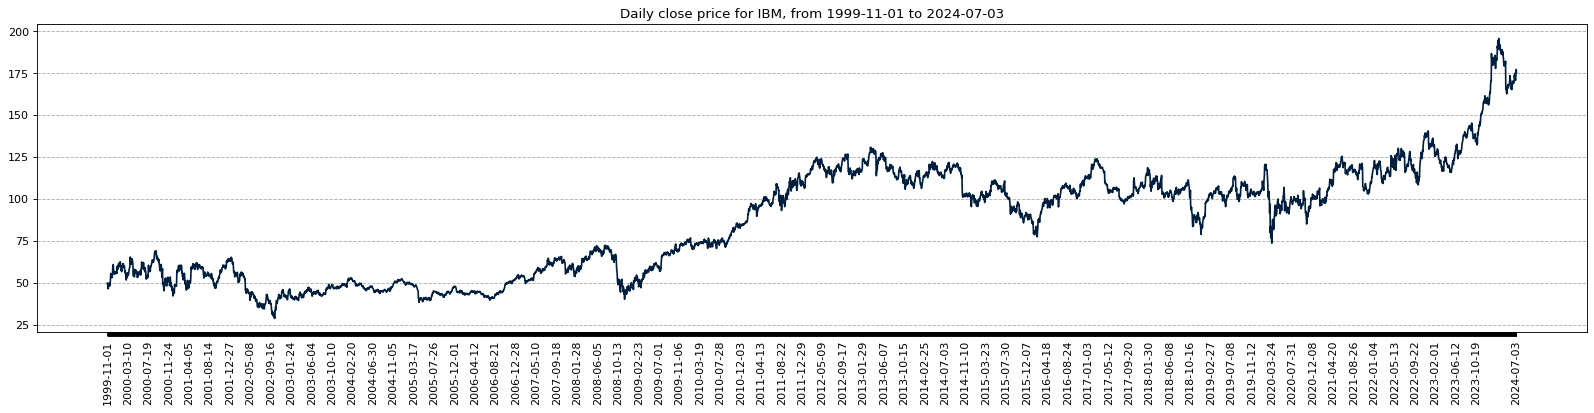

In [3]:
fig = figure(figsize=(25,5), dpi=80)
fig.patch.set_facecolor((1.0,1.0,1.0))
plt.plot(data_date, data_close_price, color=configs.config["plots"]["color_actual"])
xticks= (data_date[i] if ((i%configs.config["plots"]["xticks_interval"]==0 and 
                           (num_data_points-i)>configs.config["plots"]["xticks_interval"]) or 
                           i==num_data_points-1) else None for i in range(num_data_points))
xlticks = list(xticks)
x = np.arange(0,len(xlticks))
plt.xticks(x, xlticks, rotation='vertical') 
plt.title("Daily close price for "+configs.config["alpha_vantage"]["symbol"]+", "+display_date_range)
plt.grid(visible=True, which='major', axis='y', linestyle='--')
plt.show() 

#### Normalizing Financial Data

LSTM algorithm uses Gradient Descend as optimization technique. That means data should be scaled for faster convergence. 

In [7]:
class Normalizer():
    def __init__(self):
        self.mean = None 
        self.std = None 

    def fit_transform(self,x):
        self.mean = np.mean(x, axis=(0), keepdims=True) 
        self.std = np.std(x, axis=(0), keepdims=True) 
        normalized_x = (x-self.mean)/self.std 
        return normalized_x

    def inverse_transform(self, x):
        return (x*self.std)+self.mean 
    
scaler = Normalizer() 
normalized_data_close_price = scaler.fit_transform(data_close_price)     

In [8]:
normalized_data_close_price.shape[0] 

6207

In [9]:
normalized_data_close_price 

array([-1.11114107, -1.14167336, -1.14859821, ...,  2.71761423,
        2.784851  ,  2.7368684 ])

In [10]:
configs.config["data"]["window_size"] 

20

### Training and Validation

In [12]:
def prepare_data_x(x, window_size):
    n_row = x.shape[0]-window_size+1 
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row,window_size), strides=(x.strides[0],x.strides[0]))
    return output[:-1], output[-1] 

def prepare_data_y(x, window_size):
    output = x[window_size:]
    return output 

data_x, data_x_unseen = prepare_data_x(normalized_data_close_price, window_size=configs.config["data"]["window_size"]) 
data_y = prepare_data_y(normalized_data_close_price, window_size=configs.config["data"]["window_size"])

#### Splitting Data set

In [13]:
split_index = int(data_y.shape[0]*configs.config['data']['train_split_size'])
data_x_train = data_x[:split_index] 
data_x_val = data_x[split_index:]
data_y_train = data_y[:split_index] 
data_y_val = data_y[split_index:] 

#### Prepare data for plotting 

In [14]:
plot_y_train = np.zeros(num_data_points)
plot_y_val = np.zeros(num_data_points)

plot_y_train[configs.config['data']['window_size']:split_index+configs.config['data']['window_size']] = scaler.inverse_transform(data_y_train)
plot_y_val[split_index+configs.config['data']['window_size']:] = scaler.inverse_transform(data_y_val) 

plot_y_train = np.where(plot_y_train==0, None, plot_y_train) 
plot_y_val = np.where(plot_y_val==0, None, plot_y_val) 


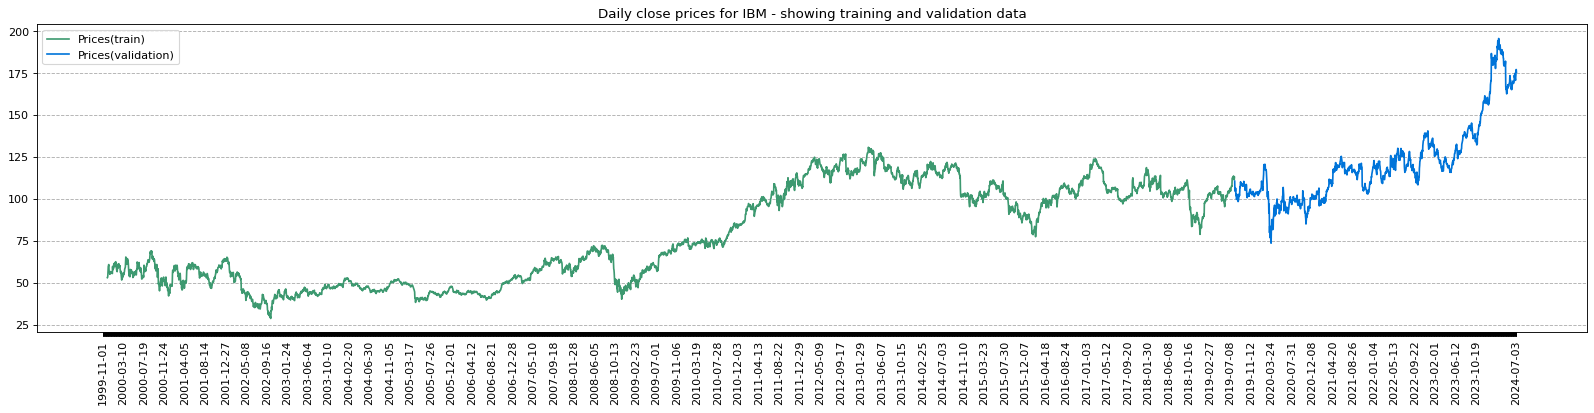

In [15]:
fig = figure(figsize=(25,5), dpi=80) 
fig.patch.set_facecolor((1.0,1.0,1.0)) 
plt.plot(data_date, plot_y_train, label='Prices(train)', color=configs.config['plots']['color_train'])
plt.plot(data_date, plot_y_val, label='Prices(validation)', color=configs.config['plots']['color_val'])
xticks = [data_date[i] if ((i%configs.config["plots"]["xticks_interval"]==0 and 
                            (num_data_points-i) > configs.config["plots"]["xticks_interval"]) or 
                            i==num_data_points-1) else None for i in range(num_data_points)] 
xllticks = list(xticks) 
x = np.arange(0,len(xllticks))
plt.xticks(x, xllticks, rotation='vertical')
plt.title("Daily close prices for " + configs.config["alpha_vantage"]["symbol"] + " - showing training and validation data")
plt.grid(visible=True, which='major', axis='y', linestyle='--')
plt.legend()
plt.show() 

In [16]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        x = np.expand_dims(x,2)
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32) 

    def __len__(self):
        return len(self.x) 

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx]) 

dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
dataset_val = TimeSeriesDataset(data_x_val, data_y_val) 

print("Train data shape : ",dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape : ",dataset_val.x.shape, dataset_val.y.shape)

train_dataloader = DataLoader(dataset_train, batch_size=configs.config['training']['batch_size'], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=configs.config['training']['batch_size'], shuffle=True)

Train data shape :  (4949, 20, 1) (4949,)
Validation data shape :  (1238, 20, 1) (1238,)


### Defining LSTM model

In [17]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__() 
        self.hidden_layer_size = hidden_layer_size 
        
        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        
        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                 nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)
    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # reshape output from hidden cell into [batch, features] for `linear_2`
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 
        
        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1] 

### Model Training 

In [13]:
def run_epoch(dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        x = x.to(configs.config["training"]["device"])
        y = y.to(configs.config["training"]["device"])

        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)

    lr = scheduler.get_last_lr()[0]

    return epoch_loss, lr

train_dataloader = DataLoader(dataset_train, batch_size=configs.config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=configs.config["training"]["batch_size"], shuffle=True)

model = LSTMModel(input_size=configs.config["model"]["input_size"], hidden_layer_size=configs.config["model"]["lstm_size"], num_layers=configs.config["model"]["num_lstm_layers"], output_size=1, dropout=configs.config["model"]["dropout"])
model = model.to(configs.config["training"]["device"])

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=configs.config["training"]["learning_rate"], betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=configs.config["training"]["scheduler_step_size"], gamma=0.1)

for epoch in range(configs.config["training"]["num_epoch"]):
    loss_train, lr_train = run_epoch(train_dataloader, is_training=True)
    loss_val, lr_val = run_epoch(val_dataloader)
    scheduler.step()
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}'
              .format(epoch+1, configs.config["training"]["num_epoch"], loss_train, loss_val, lr_train))

Epoch[1/100] | loss train:0.047920, test:0.081508 | lr:0.010000
Epoch[2/100] | loss train:0.012223, test:0.044312 | lr:0.010000
Epoch[3/100] | loss train:0.008960, test:0.032828 | lr:0.010000
Epoch[4/100] | loss train:0.009174, test:0.048753 | lr:0.010000
Epoch[5/100] | loss train:0.007663, test:0.039013 | lr:0.010000
Epoch[6/100] | loss train:0.007580, test:0.041881 | lr:0.010000
Epoch[7/100] | loss train:0.007182, test:0.054007 | lr:0.010000
Epoch[8/100] | loss train:0.007722, test:0.028481 | lr:0.010000
Epoch[9/100] | loss train:0.007502, test:0.035915 | lr:0.010000
Epoch[10/100] | loss train:0.007813, test:0.019184 | lr:0.010000
Epoch[11/100] | loss train:0.006992, test:0.042046 | lr:0.010000
Epoch[12/100] | loss train:0.006871, test:0.018586 | lr:0.010000
Epoch[13/100] | loss train:0.006651, test:0.020969 | lr:0.010000
Epoch[14/100] | loss train:0.007342, test:0.009109 | lr:0.010000
Epoch[15/100] | loss train:0.007159, test:0.020626 | lr:0.010000
Epoch[16/100] | loss train:0.00664

### Model Evaluation

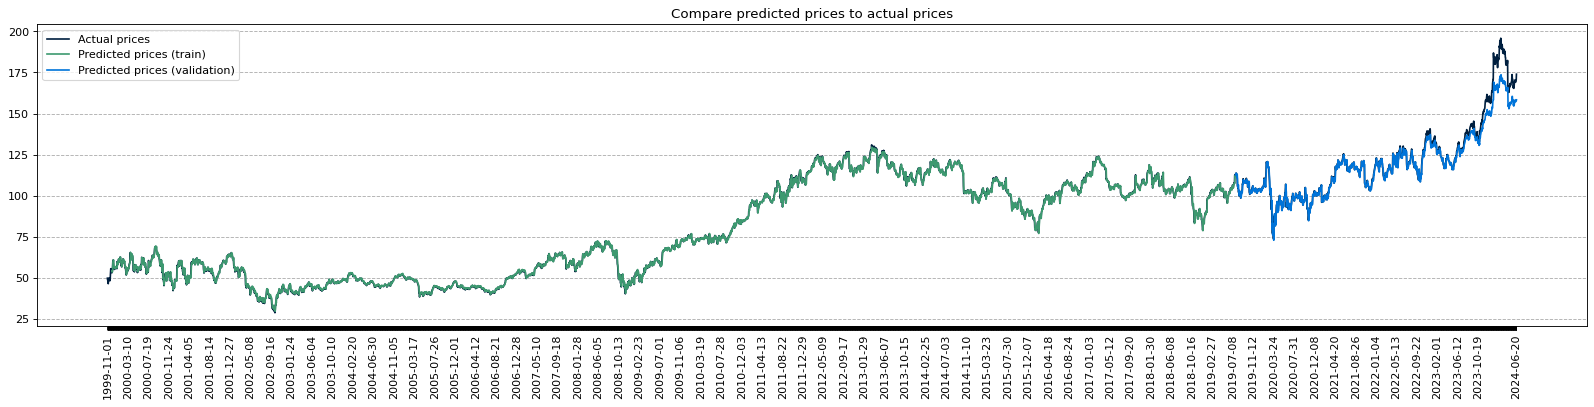

In [14]:
train_dataloader = DataLoader(dataset_train, batch_size=configs.config["training"]["batch_size"], shuffle=False)
val_dataloader = DataLoader(dataset_val, batch_size=configs.config["training"]["batch_size"], shuffle=False)

model.eval()

# predict on the training data, to see how well the model managed to learn and memorize

predicted_train = np.array([])

for idx, (x, y) in enumerate(train_dataloader):
    x = x.to(configs.config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_train = np.concatenate((predicted_train, out))

# predict on the validation data, to see how the model does

predicted_val = np.array([])

for idx, (x, y) in enumerate(val_dataloader):
    x = x.to(configs.config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_val = np.concatenate((predicted_val, out))

# prepare data for plotting

to_plot_data_y_train_pred = np.zeros(num_data_points)
to_plot_data_y_val_pred = np.zeros(num_data_points)

to_plot_data_y_train_pred[configs.config["data"]["window_size"]:split_index+configs.config["data"]["window_size"]] = scaler.inverse_transform(predicted_train)
to_plot_data_y_val_pred[split_index+configs.config["data"]["window_size"]:] = scaler.inverse_transform(predicted_val)

to_plot_data_y_train_pred = np.where(to_plot_data_y_train_pred == 0, None, to_plot_data_y_train_pred)
to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)

# plots

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, data_close_price, label="Actual prices", color=configs.config["plots"]["color_actual"])
plt.plot(data_date, to_plot_data_y_train_pred, label="Predicted prices (train)", color=configs.config["plots"]["color_pred_train"])
plt.plot(data_date, to_plot_data_y_val_pred, label="Predicted prices (validation)", color=configs.config["plots"]["color_pred_val"])
plt.title("Compare predicted prices to actual prices")
xticks = [data_date[i] if ((i%configs.config["plots"]["xticks_interval"]==0 and (num_data_points-i) > configs.config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
xsticks = list(xticks)
x = np.arange(0,len(xsticks))
plt.xticks(x, xsticks, rotation='vertical')
plt.grid(visible=True, which='major', axis='y', linestyle='--')
plt.legend()
plt.show() 

### Predicting Future Stock Price

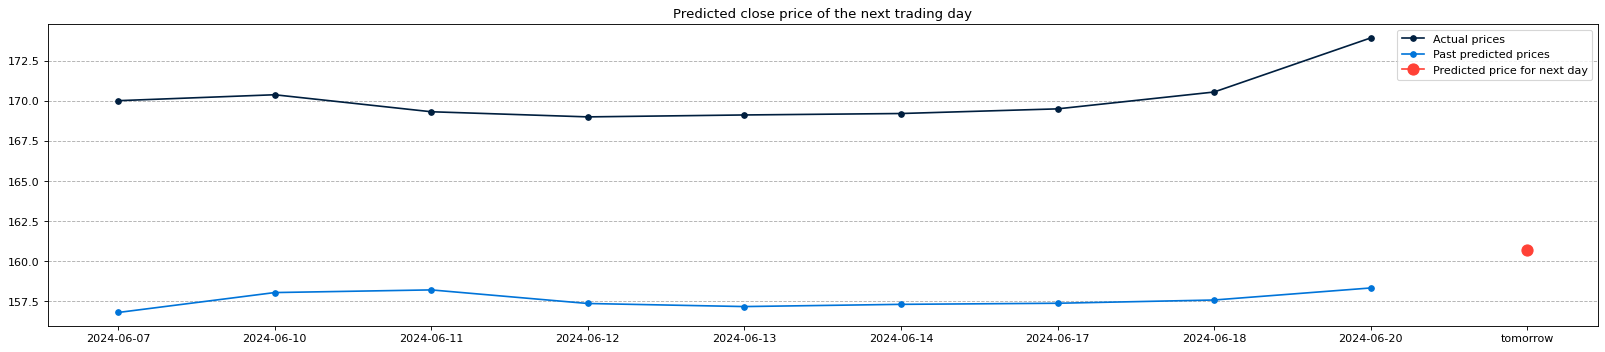

Predicted close price of the next trading day: 160.7


In [15]:
# predict the closing price of the next trading day

model.eval()

x = torch.tensor(data_x_unseen).float().to(configs.config["training"]["device"]).unsqueeze(0).unsqueeze(2) # this is the data type and shape required, [batch, sequence, feature]
prediction = model(x)
prediction = prediction.cpu().detach().numpy()

# prepare plots

plot_range = 10
to_plot_data_y_val = np.zeros(plot_range)
to_plot_data_y_val_pred = np.zeros(plot_range)
to_plot_data_y_test_pred = np.zeros(plot_range)

to_plot_data_y_val[:plot_range-1] = scaler.inverse_transform(data_y_val)[-plot_range+1:]
to_plot_data_y_val_pred[:plot_range-1] = scaler.inverse_transform(predicted_val)[-plot_range+1:]

to_plot_data_y_test_pred[plot_range-1] = scaler.inverse_transform(prediction)

to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)
to_plot_data_y_test_pred = np.where(to_plot_data_y_test_pred == 0, None, to_plot_data_y_test_pred)

# plot

plot_date_test = data_date[-plot_range+1:]
plot_date_test.append("tomorrow")

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(plot_date_test, to_plot_data_y_val, label="Actual prices", marker=".", markersize=10, color=configs.config["plots"]["color_actual"])
plt.plot(plot_date_test, to_plot_data_y_val_pred, label="Past predicted prices", marker=".", markersize=10, color=configs.config["plots"]["color_pred_val"])
plt.plot(plot_date_test, to_plot_data_y_test_pred, label="Predicted price for next day", marker=".", markersize=20, color=configs.config["plots"]["color_pred_test"])
plt.title("Predicted close price of the next trading day")
plt.grid(visible=True, which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

print("Predicted close price of the next trading day:", round(to_plot_data_y_test_pred[plot_range-1], 2)) 